In [7]:
#NEED TO RESTART KERNEL TO LOAD CHANGES TO IMPORTS :(

import sys
import os
# caution: path[0] is reserved for script path (or '' in REPL).
sys.path.insert(1, os.path.abspath('./../src'))

from data_loader import load_compressed_rept_data
from energy_channels import EnergyChannel
import plot_tools
from plot_tools import plot_l_vs_time, plot_l_cut
import datetime
import matplotlib.pyplot as plt
import spacepy.time
import numpy as np

import importlib
importlib.reload(plot_tools)

#NEED TO RESTART KERNEL TO LOAD CHANGES TO IMPORTS :(

<module 'plot_tools' from 'c:\\Dev\\Research\\REPT_Enhancements_Tool\\src\\plot_tools.py'>

Loading REPT data between: 2014-09-01 00:00:00 and 2014-10-01 00:00:00.
Loading : REPT_201409_A.npz
Loading : REPT_201410_A.npz


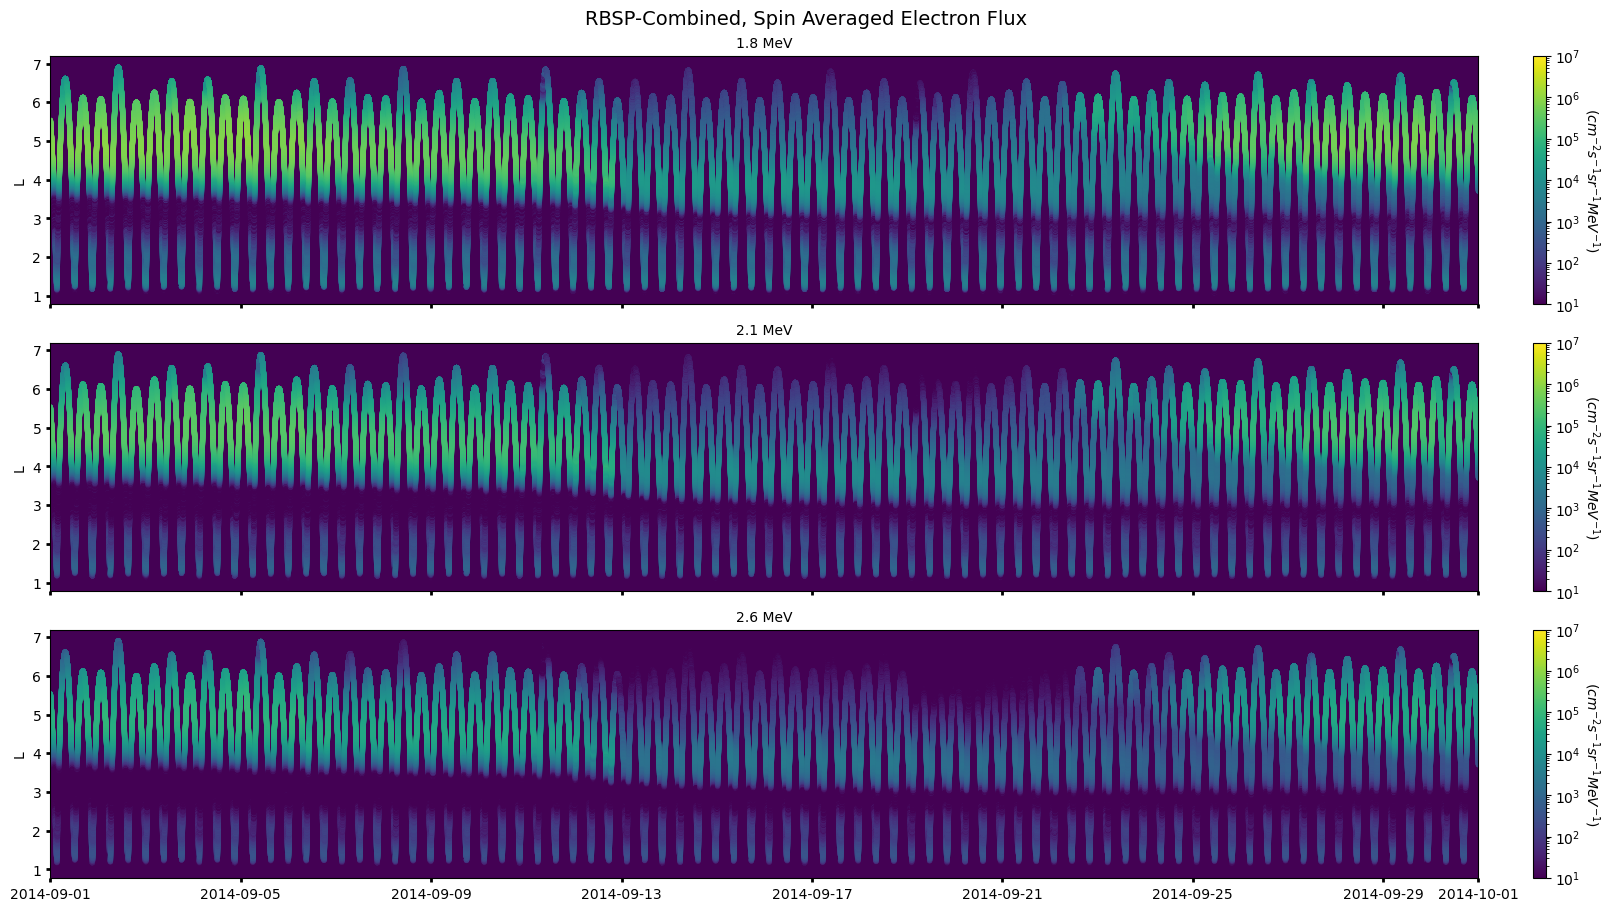

In [8]:
start = datetime.datetime(year = 2014, month = 9, day = 1)
end = datetime.datetime(year = 2014, month = 10, day = 1)

data = load_compressed_rept_data(satellite="A", start=start, end=end)

fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(16, 9)
fig.set_layout_engine("constrained")
plot_tools.plot_l_vs_time(refs=data, energy_channel=EnergyChannel.MeV_1_8, flux_min=10, flux_max=1e7, axis=axs[0])
plot_tools.plot_l_vs_time(refs=data, energy_channel=EnergyChannel.MeV_2_1, flux_min=10, flux_max=1e7, axis=axs[1])
plot_tools.plot_l_vs_time(refs=data, energy_channel=EnergyChannel.MeV_2_6, flux_min=10, flux_max=1e7, axis=axs[2])
    
axs[0].set_xlim(start, end)
axs[1].set_xlim(start, end)
axs[2].set_xlim(start, end)


fig.suptitle(f"RBSP-Combined, Spin Averaged Electron Flux", fontsize = 14)
plt.show()

fig.savefig("./test.pdf", dpi=100, format="pdf")